# Characterization of Raw Data from NHL API
___

In [22]:
import os
import findspark
import pyspark
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

In [2]:
# start spark
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/jdk1.8.0_231.jdk/Contents/Home/"
os.environ["JRE_HOME"] = "/Library/Java/JavaVirtualMachines/jdk1.8.0_231.jdk/Contents/Home/"
findspark.init("/usr/local/Cellar/apache-spark/2.4.5/libexec/")
spark = pyspark.sql\
        .SparkSession\
        .builder\
        .appName('hockey')\
        .config('spark.jars', '/Users/tanyatang/Documents/Code/resources/postgresql/postgresql-42.2.12.jar')\
        .getOrCreate()

In [3]:
# get game info
games = spark.read.jdbc(url='jdbc:postgresql://localhost/50_in_07',
                        table='game',
                        properties={'user': 'tanyatang',
                                    'password': '',
                                    'driver': 'org.postgresql.Driver'})
games.registerTempTable('games')
games.printSchema()

root
 |-- game_id: integer (nullable = true)
 |-- season: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- date_time: date (nullable = true)
 |-- date_time_GMT: timestamp (nullable = true)
 |-- away_team_id: integer (nullable = true)
 |-- home_team_id: integer (nullable = true)
 |-- away_goals: integer (nullable = true)
 |-- home_goals: integer (nullable = true)
 |-- outcome: string (nullable = true)
 |-- home_rink_side_start: string (nullable = true)
 |-- venue: string (nullable = true)
 |-- venue_link: string (nullable = true)
 |-- venue_time_zone_id: string (nullable = true)
 |-- venue_time_zone_offset: integer (nullable = true)
 |-- venue_time_zone_tz: string (nullable = true)



In [118]:
# get team info
teams = spark.read.jdbc(url='jdbc:postgresql://localhost/50_in_07',
                        table='team',
                        properties={'user': 'tanyatang',
                                    'password': '',
                                    'driver': 'org.postgresql.Driver'})
teams.registerTempTable('teams')
teams.printSchema()

root
 |-- team_id: integer (nullable = true)
 |-- franchise_id: integer (nullable = true)
 |-- short_name: string (nullable = true)
 |-- team_name: string (nullable = true)
 |-- abbreviation: string (nullable = true)
 |-- link: string (nullable = true)
 |-- active: boolean (nullable = true)



In [117]:
# get player info
players = spark.read.jdbc(url='jdbc:postgresql://localhost/50_in_07',
                          table='player',
                          properties={'user': 'tanyatang',
                                      'password': '',
                                      'driver': 'org.postgresql.Driver'})
players.registerTempTable('players')
players.printSchema()

root
 |-- player_id: integer (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- nationality: string (nullable = true)
 |-- birth_city: string (nullable = true)
 |-- primary_position: string (nullable = true)
 |-- birth_date: date (nullable = true)
 |-- link: string (nullable = true)



In [70]:
# get player play info
player_plays = spark.read.jdbc(url='jdbc:postgresql://localhost/50_in_07',
                               table='game_player_play',
                               properties={'user': 'tanyatang',
                                           'password': '',
                                           'driver': 'org.postgresql.Driver'})
player_plays.registerTempTable('playerPlays')
player_plays.printSchema()

root
 |-- play_id: string (nullable = true)
 |-- game_id: integer (nullable = true)
 |-- play_num: integer (nullable = true)
 |-- player_id: integer (nullable = true)
 |-- player_type: string (nullable = true)
 |-- event: string (nullable = true)
 |-- winner: string (nullable = true)



In [100]:
# get skater info
skaters = spark.read.jdbc(url='jdbc:postgresql://localhost/50_in_07',
                          table='game_skater',
                          properties={'user': 'tanyatang',
                                      'password': '',
                                      'driver': 'org.postgresql.Driver'})
skaters.registerTempTable('skaters')
skaters.printSchema()

root
 |-- game_id: integer (nullable = true)
 |-- player_id: integer (nullable = true)
 |-- team_id: integer (nullable = true)
 |-- time_on_ice: integer (nullable = true)
 |-- assists: integer (nullable = true)
 |-- goals: integer (nullable = true)
 |-- shots: integer (nullable = true)
 |-- hits: integer (nullable = true)
 |-- power_play_goals: integer (nullable = true)
 |-- power_play_assists: integer (nullable = true)
 |-- penalty_minutes: integer (nullable = true)
 |-- faceoff_wins: integer (nullable = true)
 |-- faceoff_taken: integer (nullable = true)
 |-- takeaways: integer (nullable = true)
 |-- giveaways: integer (nullable = true)
 |-- short_handed_goals: integer (nullable = true)
 |-- short_handed_assists: integer (nullable = true)
 |-- blocked: integer (nullable = true)
 |-- plus_minus: integer (nullable = true)
 |-- even_time_on_ice: integer (nullable = true)
 |-- short_handed_time_on_ice: integer (nullable = true)
 |-- power_play_time_on_ice: integer (nullable = true)



We have imported the game and team tables from our database. The game table contains information about every game played from the 2010-2011 season to the 2018-2019 season. The team table contains information about all active teams from the 2010-2011 season to the 2018-2019 season. 

### Comparison of Number of Games Won
___

One of the first analyses we can do is to look at the distribution of winning games across teams and seasons, categorized by being home or away. 

In [87]:
games_won = spark.sql("""
SELECT a.team, a.season, a.game_count AS home, b.game_count AS away
FROM
(SELECT COUNT(1) AS game_count, home_team_id AS team, season
FROM games
WHERE outcome = 'home win SO'
OR outcome = 'home win OT'
OR outcome = 'home win REG'
GROUP BY home_team_id, season) AS a
FULL OUTER JOIN
(SELECT COUNT(1) AS game_count, away_team_id AS team, season
FROM games
WHERE outcome = 'away win SO'
OR outcome = 'away win OT'
OR outcome = 'away win REG'
GROUP BY away_team_id, season) AS b
ON a.team = b.team
AND a.season = b.season
ORDER BY a.team, a.season
""")
games_won.show(10)

+----+--------+----+----+
|team|  season|home|away|
+----+--------+----+----+
|   1|20102011|  22|  16|
|   1|20112012|  31|  31|
|   1|20122013|  13|   6|
|   1|20132014|  21|  14|
|   1|20142015|  19|  13|
|   1|20152016|  19|  19|
|   1|20162017|  16|  12|
|   1|20172018|  24|  21|
|   1|20182019|  20|  11|
|   2|20102011|  17|  13|
+----+--------+----+----+
only showing top 10 rows



The preceding query counts all winning home and away games and groups the counts by team and season. There is currently no differentiation between different types of wins, i.e. shootout vs overtime vs regular. 

In [130]:
seasons = {20102011: 1,
           20112012: 2,
           20122013: 3,
           20132014: 4,
           20142015: 5,
           20152016: 6,
           20162017: 7,
           20172018: 8,
           20182019: 9}

There are too many teams to plot in one graph, so we will split the results into three graphs. Each graph will show the split between home and away games won for each team. There are five unique teams, the ATL and PHX teams no longer exist so their data stops at 2011 and 2014, respectively. On the other hand, WPG, ARI, and VGK are new teams introduced after 2010, so their data starts at 2011, 2014, and 2017, respectively. 

*Note: the 2012-2013 season was a shortened season due to labour disputes so only 48 games were played in comparison to the usual 82 game-season.*

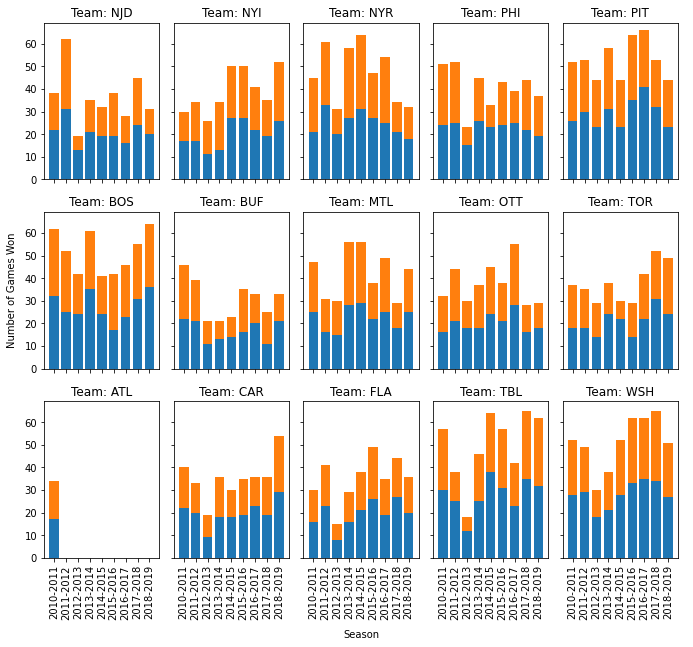

In [142]:
# plot data for teams 1 to 15
fig, ax = plt.subplots(3, 5, figsize=(10, 10), sharex=True, sharey=True)
for i in range(3):
    for j in range(5):
        team = i * 5 + j + 1
        team_name = teams.filter(teams['team_id'] == team).select('abbreviation').collect()[0].abbreviation
        games_won_per_team = games_won.filter(games_won['team'] == team)
        x = list(map(lambda x: x.season,
                 games_won_per_team.select('season').collect()))
        x_vals = np.arange(seasons[x[0]] - 1, seasons[x[len(x) - 1]])
        home_wins = list(map(lambda x: x.home,
                             games_won_per_team.select('home').collect()))
        away_wins = list(map(lambda x: x.away,
                             games_won_per_team.select('away').collect()))
        ax[i][j].bar(x_vals,
                     home_wins)
        ax[i][j].bar(x_vals,
                     away_wins,
                     bottom=home_wins)
        ax[i][j].bar(np.arange(0, 9), [0] * 9)
        ax[i][j].set_title(f'Team: {team_name}')
        ax[i][j].set_xticks(np.arange(0, 9))
        ax[i][j].set_xticklabels(['2010-2011', '2011-2012',
                                  '2012-2013', '2013-2014',
                                  '2014-2015', '2015-2016',
                                  '2016-2017', '2017-2018',
                                  '2018-2019'], 
                                 rotation='vertical')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none',
                top=False,
                bottom=False,
                left=False,
                right=False)
plt.xlabel('Season', labelpad=55)
plt.ylabel('Number of Games Won')
fig.tight_layout()
plt.show()

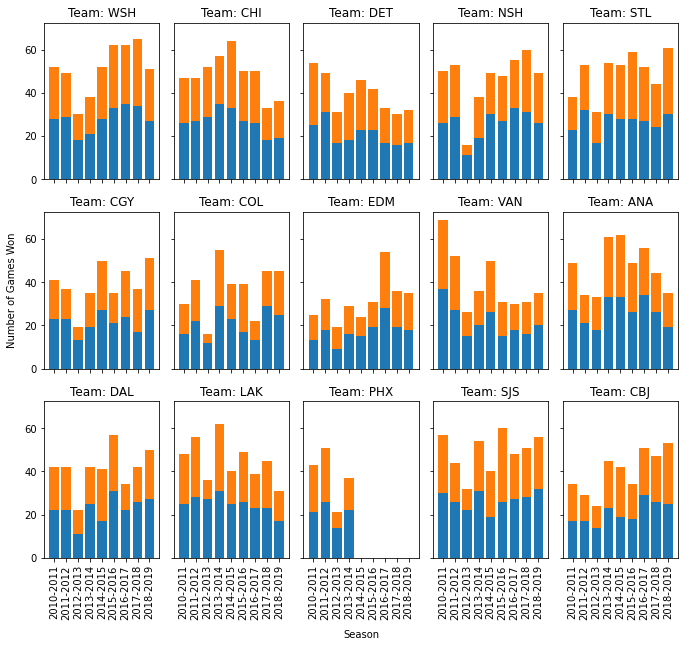

In [143]:
# plot data for teams 16 to 30
fig, ax = plt.subplots(3, 5, figsize=(10, 10), sharex=True, sharey=True)
for i in range(3):
    for j in range(5):
        team = i * 5 + j + 15
        team_name = teams.filter(teams['team_id'] == team).select('abbreviation').collect()[0].abbreviation
        games_won_per_team = games_won.filter(games_won['team'] == team)
        x = list(map(lambda x: x.season,
                 games_won_per_team.select('season').collect()))
        x_vals = np.arange(seasons[x[0]] - 1, seasons[x[len(x) - 1]])
        home_wins = list(map(lambda x: x.home,
                             games_won_per_team.select('home').collect()))
        away_wins = list(map(lambda x: x.away,
                             games_won_per_team.select('away').collect()))
        ax[i][j].bar(x_vals,
                     home_wins)
        ax[i][j].bar(x_vals,
                     away_wins,
                     bottom=home_wins)
        ax[i][j].bar(np.arange(0, 9), [0] * 9)
        ax[i][j].set_title(f'Team: {team_name}')
        ax[i][j].set_xticks(np.arange(0, 9))
        ax[i][j].set_xticklabels(['2010-2011', '2011-2012',
                                  '2012-2013', '2013-2014',
                                  '2014-2015', '2015-2016',
                                  '2016-2017', '2017-2018',
                                  '2018-2019'], 
                                 rotation='vertical')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none',
                top=False,
                bottom=False,
                left=False,
                right=False)
plt.xlabel('Season', labelpad=55)
plt.ylabel('Number of Games Won')
fig.tight_layout()
plt.show()

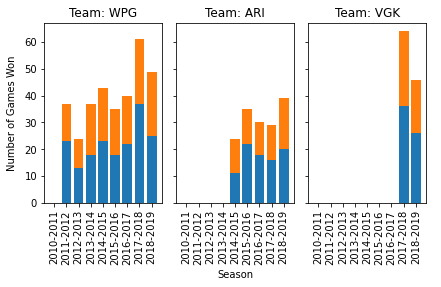

In [146]:
# plot data from 52 to 54
fig, ax = plt.subplots(1, 3, figsize=(6.5, 5), sharex=True, sharey=True)
for i in range(3):
    team = 52 + i
    team_name = teams.filter(teams['team_id'] == team).select('abbreviation').collect()[0].abbreviation
    games_won_per_team = games_won.filter(games_won['team'] == team)
    x = list(map(lambda x: x.season,
                 games_won_per_team.select('season').collect()))
    x_vals = np.arange(seasons[x[0]] - 1, seasons[x[len(x) - 1]])
    home_wins = list(map(lambda x: x.home,
                         games_won_per_team.select('home').collect()))
    away_wins = list(map(lambda x: x.away,
                         games_won_per_team.select('away').collect()))
    ax[i].bar(x_vals,
              home_wins)
    ax[i].bar(x_vals,
              away_wins,
              bottom=home_wins)
    ax[i].bar(np.arange(0, 9), [0] * 9)
    ax[i].set_title(f'Team: {team_name}')
    ax[i].set_xticks(np.arange(0, 9))
    ax[i].set_xticklabels(['2010-2011', '2011-2012',
                           '2012-2013', '2013-2014',
                           '2014-2015', '2015-2016',
                           '2016-2017', '2017-2018',
                           '2018-2019'],
                          rotation='vertical')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none',
                top=False,
                bottom=False,
                left=False,
                right=False)
plt.xlabel('Season', labelpad=50)
plt.ylabel('Number of Games Won')
fig.tight_layout()
plt.show()

## Goal Differentials
___

Next, let us take a look at how the goal differential data is distributed for each team. The goal differential is calculated by taking the current team's goal score in a game and subtract from it the opposing team's goal score in a game. 

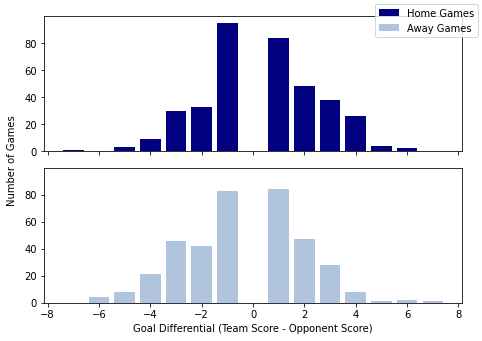

In [58]:
# only collect and plot data for test team
test_team = 30
away_diff_1 = spark.sql(f"""
SELECT (away_goals - home_goals) AS goal_diff
FROM games
WHERE away_team_id = {test_team}
""")
home_diff_1 = spark.sql(f"""
SELECT (home_goals - away_goals) AS goal_diff
FROM games
WHERE home_team_id = {test_team}
""")
home_points = list(map(lambda x: x.goal_diff,
                       home_diff_1.collect()))
away_points = list(map(lambda x: x.goal_diff,
                       away_diff_1.collect()))
home_counts = np.unique(home_points, return_counts=True)
away_counts = np.unique(away_points, return_counts=True)
fig, ax = plt.subplots(2, 1, figsize=(7, 5), sharex=True, sharey=True)
ax[0].bar(home_counts[0], home_counts[1], color='navy', label='Home Games')
ax[1].bar(away_counts[0], away_counts[1], color='lightsteelblue', label='Away Games')
fig.legend()
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none',
                top=False,
                bottom=False,
                left=False,
                right=False)
plt.xlabel('Goal Differential (Team Score - Opponent Score)')
plt.ylabel('Number of Games')
fig.tight_layout()
plt.show()

In [67]:
# plot goal differential data for all teams and save figures
team_ids = np.append(np.arange(1, 31), [52, 53, 54])
date = '060620'
for team in teams_ids:
    away_diff = spark.sql(f"""
    SELECT (away_goals - home_goals) AS goal_diff
    FROM games
    WHERE away_team_id = {team}
    """)
    home_diff = spark.sql(f"""
    SELECT (home_goals - away_goals) AS goal_diff
    FROM games
    WHERE home_team_id = {team}
    """)
    home_points = list(map(lambda x: x.goal_diff,
                           home_diff.collect()))
    away_points = list(map(lambda x: x.goal_diff,
                           away_diff.collect()))
    home_counts = np.unique(home_points, return_counts=True)
    away_counts = np.unique(away_points, return_counts=True)
    fig, ax = plt.subplots(2, 1, figsize=(7, 5), sharex=True, sharey=True)
    ax[0].bar(home_counts[0], home_counts[1], color='navy', label='Home Games')
    ax[1].bar(away_counts[0], away_counts[1], color='lightsteelblue', label='Away Games')
    fig.legend()
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none',
                    top=False,
                    bottom=False,
                    left=False,
                    right=False)
    plt.xlabel('Goal Differential (Team Score - Opponent Score)')
    plt.ylabel('Number of Games')
    fig.tight_layout()
    plt.savefig(f'figs/goal_differential/team_{team}_{dates}.svg',
                format='svg')
    plt.close()

## Player Event Outcomes
___

There are four major categories of plays a player experiences on the ice excluding penalties. A player comes out of a play as a loser or winner depending on the play outcome. For each player, we can plot the number of wins and loses in each category. 

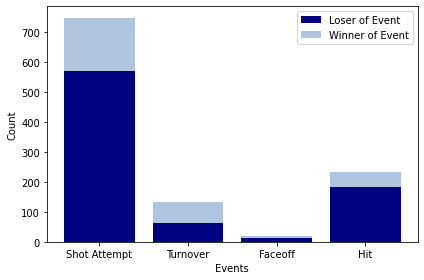

In [93]:
# only collect and plot data for test player
test_player = 8460577
events = ['Shot Attempt', 'Turnover', 'Faceoff', 'Hit']
fig, ax = plt.subplots()
for k, event in enumerate(events):
    win_count = spark.sql(f"""
    SELECT COUNT(*) AS count
    FROM playerPlays
    WHERE event = '{event}'
    AND player_id = {test_player}
    AND winner = 'Winner'
    """)
    win_count = win_count.collect()[0]['count']
    lose_count = spark.sql(f"""
    SELECT COUNT(*) AS count
    FROM playerPlays
    WHERE event = '{event}'
    AND player_id = {test_player}
    AND winner = 'Loser'
    """)
    lose_count = lose_count.collect()[0]['count']
    if k == 0:
        ax.bar(k,
               lose_count,
               color='navy',
               label='Loser of Event')
        ax.bar(k,
               win_count,
               bottom=lose_count,
               color='lightsteelblue',
               label='Winner of Event')
    else:
        ax.bar(k, lose_count, color='navy')
        ax.bar(k, win_count, bottom=lose_count, color='lightsteelblue')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(events)
ax.set_xlabel('Events')
ax.set_ylabel('Count')
ax.legend()
fig.tight_layout()
plt.show()

In [99]:
# plot data for all players
player_ids = list(map(lambda x: x.player_id,
                      players.select('player_id').collect()))
date ='060620'
for player in player_ids:
    events = ['Shot Attempt', 'Turnover', 'Faceoff', 'Hit']
    counts = []
    fig, ax = plt.subplots()
    for k, event in enumerate(events):
        win_count = spark.sql(f"""
        SELECT COUNT(*) AS count
        FROM playerPlays
        WHERE event = '{event}'
        AND player_id = {player}
        AND winner = 'Winner'
        """)
        win_count = win_count.collect()[0]['count']
        lose_count = spark.sql(f"""
        SELECT COUNT(*) AS count
        FROM playerPlays
        WHERE event = '{event}'
        AND player_id = {player}
        AND winner = 'Loser'
        """)
        lose_count = lose_count.collect()[0]['count']
        counts.append(win_count)
        counts.append(lose_count)
        if k == 0:
            ax.bar(k,
                   lose_count,
                   color='navy',
                   label='Loser of Event')
            ax.bar(k,
                   win_count,
                   bottom=lose_count,
                   color='lightsteelblue',
                   label='Winner of Event')
        else:
            ax.bar(k, lose_count, color='navy')
            ax.bar(k, win_count, bottom=lose_count, color='lightsteelblue')
    if sum(counts) > 0:
        ax.set_xticks([0, 1, 2, 3])
        ax.set_xticklabels(events)
        ax.set_xlabel('Events')
        ax.set_ylabel('Count')
        ax.legend()
        fig.tight_layout()
        plt.savefig(f'figs/player_play_outcomes/player_{player}_{date}.svg',
                    format='svg')
    plt.close()

DESCRIBE

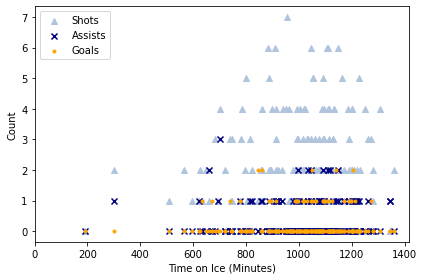

In [126]:
# only collect and plot data for test player
test_player = 8460577
data = spark.sql(f"""
SELECT player_id, time_on_ice, assists, goals, shots
FROM skaters
WHERE player_id = {test_player}
""")
time_on_ice = list(map(lambda x: x.time_on_ice, data.collect()))
assists = list(map(lambda x: x.assists, data.collect()))
goals = list(map(lambda x: x.goals, data.collect()))
shots = list(map(lambda x: x.shots, data.collect()))
fig, ax = plt.subplots()
ax.scatter(time_on_ice, shots, marker='^', color='lightsteelblue', label='Shots')
ax.scatter(time_on_ice, assists, marker='x', color='navy', label='Assists')
ax.scatter(time_on_ice, goals, marker='.', color='orange', label='Goals')
ax.set_xlim(left=0)
ax.set_xlabel('Time on Ice (Minutes)')
ax.set_ylabel('Count')
ax.legend()
fig.tight_layout()
plt.show()

In [127]:
# plot data for all players
player_ids = list(map(lambda x: x.player_id,
                      players.select('player_id').collect()))
date = '060620'
for player in player_ids:
    data = spark.sql(f"""
    SELECT player_id, time_on_ice, assists, goals, shots
    FROM skaters
    WHERE player_id = {player}
    """)
    time_on_ice = list(map(lambda x: x.time_on_ice, data.collect()))
    assists = list(map(lambda x: x.assists, data.collect()))
    goals = list(map(lambda x: x.goals, data.collect()))
    shots = list(map(lambda x: x.shots, data.collect()))
    if len(time_on_ice) > 0:
        fig, ax = plt.subplots()
        ax.scatter(time_on_ice, shots, marker='^', color='lightsteelblue', label='Shots')
        ax.scatter(time_on_ice, assists, marker='x', color='navy', label='Assists')
        ax.scatter(time_on_ice, goals, marker='.', color='orange', label='Goals')
        ax.set_xlim(left=0)
        ax.set_xlabel('Time on Ice (Minutes)')
        ax.set_ylabel('Count')
        ax.legend()
        fig.tight_layout()
        plt.savefig(f'figs/time_on_ice_comparison/player_{player}_{date}.png',
                    format='png')
        plt.close()